# Authors: Nazmi Bunjaku (2775692), Geri Bakushi (2819369)
# CIS 492 - Big Data Analytics
# Professor Sunnie Chung
# Final Project - IMDB Sentiment Analysis
# May 05, 2023

### Import necessary packages/libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re, string, unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os
print(os.listdir("../IMDB Sentiment Analysis/input"))
import warnings
warnings.filterwarnings('ignore')

['.DS_Store', 'IMDB Dataset.csv']


### Load training dataset

In [2]:
imdb_data = pd.read_csv("input/IMDB Dataset.csv")
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Explanatory Data Analysis (EDA)

In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Sentiment Analysis Count

In [4]:
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Split the training dataset

In [5]:
# Training data
train_reviews = imdb_data.review[:40000]
train_sentiments = imdb_data.sentiment[:40000]

# Testing data
test_reviews = imdb_data.review[40000:]
test_sentiments = imdb_data.sentiment[40000:]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


### Text Normalization

In [6]:
# Tokenization of text
tokenizer = ToktokTokenizer()

# Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

### Removing HTML strips and text noise

In [7]:
# Removal of HTML strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing text noise
def denoise_text(text):
    text = strip_html(text)
    text = remove_square_brackets(text)
    return text

# Call function on "review" column
imdb_data['review'] = imdb_data['review'].apply(denoise_text)
print(imdb_data['review'])

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. The filming tec...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object


### Remove special characters

In [8]:
def remove_special_chars(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# Apply function on "review" column
imdb_data['review'] = imdb_data['review'].apply(remove_special_chars)
print(imdb_data['review'])

0        One of the other reviewers has mentioned that ...
1        A wonderful little production The filming tech...
2        I thought this was a wonderful way to spend ti...
3        Basically theres a family where a little boy J...
4        Petter Matteis Love in the Time of Money is a ...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot bad dialogue bad acting idiotic direc...
49997    I am a Catholic taught in parochial elementary...
49998    Im going to have to disagree with the previous...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object


### Text Stemmatization

In [9]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review'] = imdb_data['review'].apply(simple_stemmer)

### Removing Stopwords

In [10]:
stop = set(stopwords.words('english'))

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)

### Normalize Training Reviews

In [11]:
norm_train_reviews = imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

### Normalize Test Reviews

In [12]:
norm_test_reviews = imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

### Bag of Words (BoW)

In [13]:
# Initialize Count Vectorizer
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))

# Transform train reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews)

# Transform test reviews
cv_test_reviews = cv.transform(norm_test_reviews)

print('BoW_cv_TRAIN: ', cv_train_reviews.shape)
print('BoW_cv_TEST: ', cv_train_reviews.shape)

BoW_cv_TRAIN:  (40000, 6209089)
BoW_cv_TEST:  (40000, 6209089)


### Term Frequency-Inverse Document Frequency model (TFIDF)

In [14]:
#TFIDF Vectorizer
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))

# Transformed Training Reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)

# Transformed Test Reviews
tv_test_reviews = tv.transform(norm_test_reviews)

print('TFIDF_TRAIN: ', tv_train_reviews.shape)
print('TFIDF_TEST: ', tv_test_reviews.shape)

TFIDF_TRAIN:  (40000, 6209089)
TFIDF_TEST:  (10000, 6209089)


### Labeling the sentiment analysis text

In [15]:
lb = LabelBinarizer()

# Transformed Sentiment Data
sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


### Split the sentiment Data

In [35]:
train_sentiment_data = sentiment_data[:40000]
test_sentiment_data = sentiment_data[40000:]

print(train_sentiment_data)
print(test_sentiment_data)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


### Modeling the Dataset

In [17]:
# Training the model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

# Fitting the model for Bag of Words
lr_bow = lr.fit(cv_train_reviews, train_sentiment_data)
print(lr_bow)

# Fitting the model for TFIDF Features
lr_tfidf = lr.fit(tv_train_reviews, train_sentiment_data)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


### Perform Logistic Regression on test Dataset

In [18]:
# Predicting the model for BoW
lr_bow_predict = lr.predict(cv_test_reviews)
print(lr_bow_predict)

# Predicting the model for TFIDF
lr_tfidf_predict = lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Accuracy of the model

In [19]:
# Accuracy score for the BoW model
lr_bow_accuracy = accuracy_score(test_sentiment_data, lr_bow_predict)
print('Logistic Regression - Bag of Words Accuracy: ', lr_bow_accuracy)

lr_tfidf_accuracy = accuracy_score(test_sentiment_data, lr_tfidf_predict)
print('Logistic Regression - TDIDF Accuracy: ', lr_tfidf_accuracy)

Logistic Regression - Bag of Words Accuracy:  0.7512
Logistic Regression - TDIDF Accuracy:  0.75


### Output the Classification Report

In [20]:
# Classification Report for BoW
lr_bow_report = classification_report(test_sentiment_data, lr_bow_predict, target_names=['Positive', 'Negative'])
print(lr_bow_report)

# Classification Report for TFIDF
lr_tfidf_report = classification_report(test_sentiment_data, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



### Confusion Matrix

In [21]:
# BoW
cm_bow = confusion_matrix(test_sentiment_data, lr_bow_predict, labels=[1,0])
print(cm_bow)

cm_tfidf = confusion_matrix(test_sentiment_data, lr_tfidf_predict, labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


### Stochastic Gradient Descent or Linear Support Vector Machines for BoW and TFIDF Features

In [22]:
# Training the linear svm
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

# Fitting the SVM for BoW
svm_bow = svm.fit(cv_train_reviews, train_sentiment_data)
print(svm_bow)

# Fitting the SVM for TFIDF
svm_tfidf = svm.fit(tv_train_reviews, train_sentiment_data)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


### Evaluate Model Perfomance on Test Data

In [23]:
# Predicting the model for BoW
svm_bow_predict = svm.predict(cv_test_reviews)
print('SVM BoW Score: ', svm_bow_predict)

# Predicting the model for TFIDF
svm_tfidf_predict = svm.predict(tv_test_reviews)
print('SVM TFIDF Score: ', svm_tfidf_predict)

SVM BoW Score:  [1 1 0 ... 1 1 1]
SVM TFIDF Score:  [1 1 1 ... 1 1 1]


### Accuracy of the Model on Test Data

In [24]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiment_data, svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiment_data, svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


### Output the classification report

In [25]:
# BoW
svm_bow_report = classification_report(test_sentiment_data, svm_bow_predict, target_names=['Positive', 'Negative'])
print(svm_bow_report)

# TFIDF
svm_tfidf_report = classification_report(test_sentiment_data, svm_tfidf_predict, target_names=['Positive', 'Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



### Confusion Matrix

In [26]:
# BoW
cm_bow = confusion_matrix(test_sentiment_data, svm_bow_predict, labels=[1,0])
print(cm_bow)

# TFIDF
cm_tfidf = confusion_matrix(test_sentiment_data, svm_tfidf_predict, labels=[1,0])
print(cm_tfidf)

[[4948   59]
 [4112  881]]
[[5007    0]
 [4888  105]]


### Multinomial Bayes for BoW & TFIDF features

In [38]:
# Training the model
mnb = MultinomialNB()
# Fitting the SVM for BoW
mnb_bow = mnb.fit(cv_train_reviews, train_sentiment_data)
print(mnb_bow)
# Fitting the SVM for TFIDF
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiment_data)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


### Model Performance on Test Data

In [39]:
# Predicting the model for BoW
mnb_bow_predict = mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

# Predicting the model for TFIDF
mnb_tfidf_predict = mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Accuracy of the Model

In [41]:
# Accuracy for MNB BoW
mnb_bow_score = accuracy_score(test_sentiment_data, mnb_bow_predict)
print('mnb_bow_score: ', mnb_bow_score)

# Accuracy for MNB TFIDF
mnb_tfidf_score = accuracy_score(test_sentiment_data, mnb_tfidf_predict)
print('mnb_tfidf_score: ', mnb_tfidf_score)

mnb_bow_score:  0.751
mnb_tfidf_score:  0.7509


### Classification Report

In [46]:
# BoW
mnb_bow_report = classification_report(test_sentiment_data, mnb_bow_predict, target_names = ['Positive', 'Negative'])
print(mnb_bow_report)

# TFIDF
mnb_tfidf_report = classification_report(test_sentiment_data, mnb_tfidf_predict, target_names = ['Positive', 'Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [44]:
# Confusion Matrix for BoW
cm_bow = confusion_matrix(test_sentiment_data, mnb_bow_predict, labels=[1,0])
print(cm_bow)

# Confusion Matrix for TFIDF
cm_tfidf = confusion_matrix(test_sentiment_data, mnb_tfidf_predict, labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


### WordCloud for Negative Reviews

<function matplotlib.pyplot.show(close=None, block=None)>

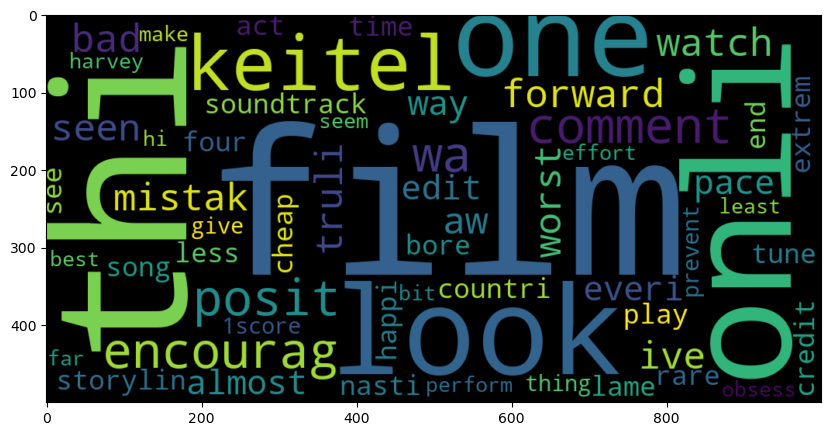

In [48]:
# WordCloud for Negative Reviews
plt.figure(figsize=(10,10))
negative_text = norm_train_reviews[8]
word_cloud = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=word_cloud.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### WordCloud for Positive Reviews

<function matplotlib.pyplot.show(close=None, block=None)>

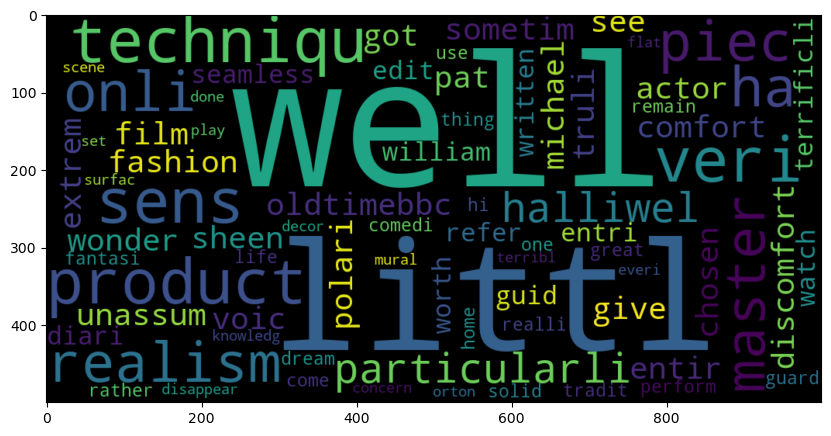

In [49]:
plt.figure(figsize=(10,10))
positive_text = norm_train_reviews[1]
word_cloud = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=word_cloud.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show